In [39]:
#Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [5]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Load your CSV file into a Pandas DataFrame
file_path = "/content/Book1.csv"
df = pd.read_csv(file_path)

In [ ]:
# Viewing the Dataframe
df

,Sentence,Sentiment,Processed_Sentence
0,I feel terrible today.,Negative,feel terrible today .
1,This situation is not good at all.,Negative,situation good .
2,I'm really disappointed in the outcome.,Negative,'m really disappointed outcome .
3,The food was awful and tasteless.,Negative,food awful tasteless .
4,I have a terrible headache.,Negative,terrible headache .
...,...,...,...
494,The constant improvement is a testament to our...,Negative,constant improvement testament commitment .
495,I'm overjoyed by the positive impact we're cre...,Negative,'m overjoyed positive impact 're creating .
496,Every success story starts with determination.,Negative,Every success story start determination .
497,Your kindness adds warmth to our interactions.,Negative,kindness add warmth interaction .


In [8]:
# Impute unlabeled sentiments
imputer = SimpleImputer(strategy='constant', fill_value='Negative')
df['Sentiment'] = imputer.fit_transform(df[['Sentiment']])

In [9]:
#viewing the dataframe after imputing the unlabeled sentiments
df

,Sentence,Sentiment
0,I feel terrible today.,Negative
1,This situation is not good at all.,Negative
2,I'm really disappointed in the outcome.,Negative
3,The food was awful and tasteless.,Negative
4,I have a terrible headache.,Negative
...,...,...
494,The constant improvement is a testament to our...,Negative
495,I'm overjoyed by the positive impact we're cre...,Negative
496,Every success story starts with determination.,Negative
497,Your kindness adds warmth to our interactions.,Negative


In [10]:
# Text preprocessing pipeline
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin tokens into a sentence
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [11]:
# Apply text preprocessing to the 'Sentence' column
df['Processed_Sentence'] = df['Sentence'].apply(preprocess_text)

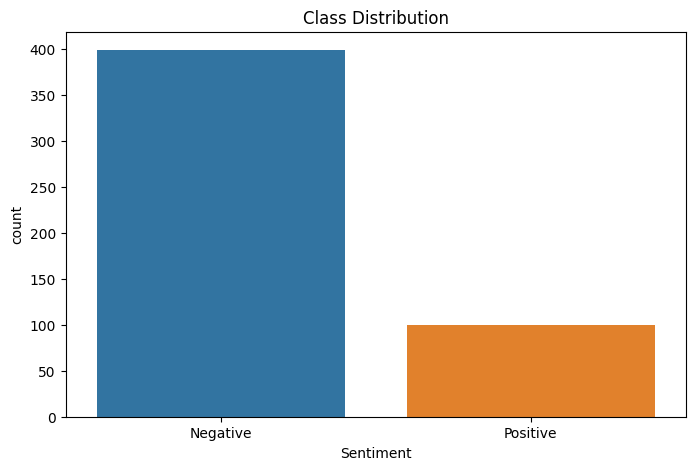

In [34]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df)
plt.title('Class Distribution')
plt.show()

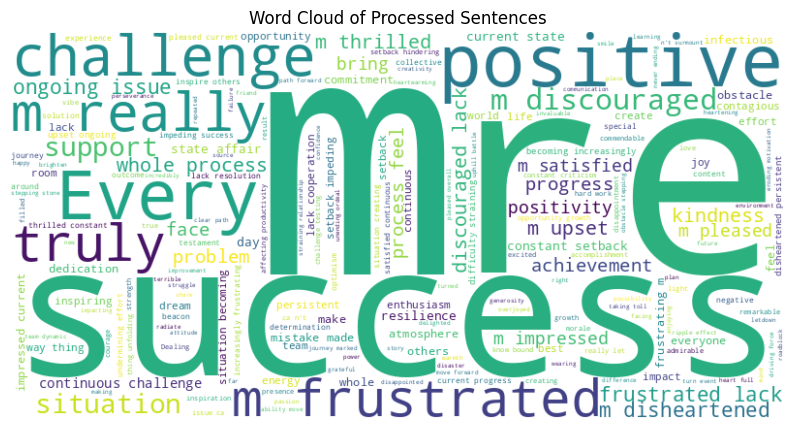

In [35]:
# Word Cloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Processed_Sentence']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Sentences')
plt.show()

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['Processed_Sentence']], df['Sentiment'], test_size=0.2, random_state=1000)

In [13]:
# Identify categorical columns
categorical_cols = []

In [14]:
# Text vectorization and model pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'Processed_Sentence'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))
])

In [15]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text', TfidfVectorizer(),
                                                  'Processed_Sentence'),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', SVC(kernel='linear'))])

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [17]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.85


In [19]:
#Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.97      0.91        80
    Positive       0.78      0.35      0.48        20

    accuracy                           0.85       100
   macro avg       0.82      0.66      0.70       100
weighted avg       0.84      0.85      0.83       100



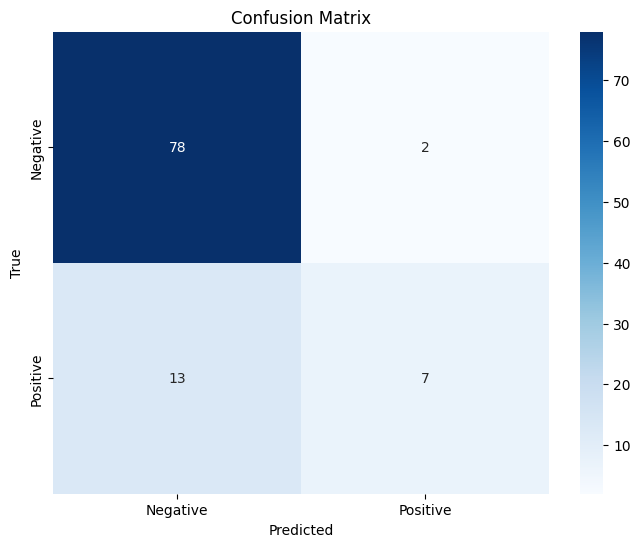

In [36]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

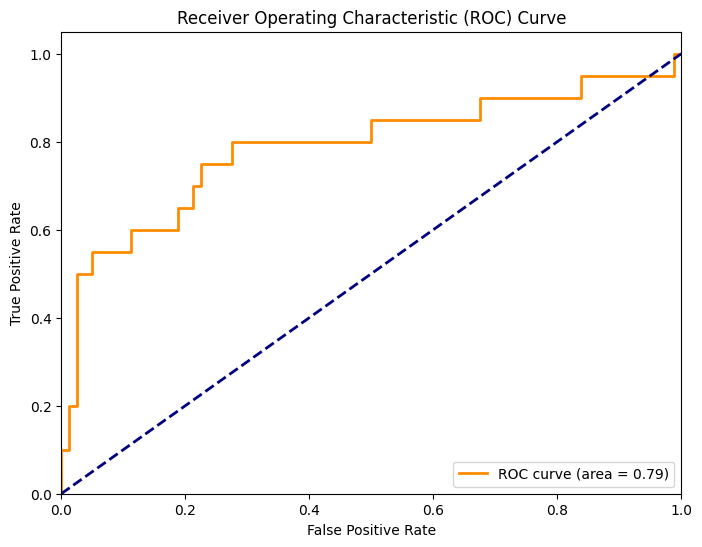

In [37]:
# Get predicted probabilities for the positive class
y_prob = model.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='Positive')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

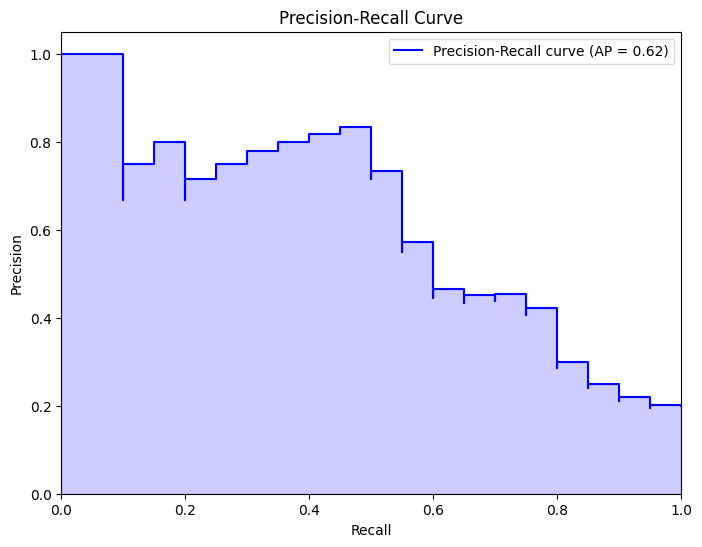

In [38]:
# Get predicted probabilities for the positive class
y_prob = model.decision_function(X_test)

# Compute precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label='Positive')
average_precision = average_precision_score(y_test, y_prob, pos_label='Positive')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()